In [1]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image
import pandas as pd
import plotly.express as px
from IPython import display

In [39]:
import selfsupmotion.zero_shot_pose as zsp
import selfsupmotion.geometry as geo
zsp.use_cupy = False
#experiment = zsp.ExperimentHandlerFile("../output/pretrain_224_coordconv/")
#experiment = zsp.ExperimentHandlerFile("../output/pretrain_224_ntxent/")
experiment = zsp.ExperimentHandlerFile("../gold/pretrain_224_uniform/")

#embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [40]:
from sklearn.metrics import average_precision_score

In [41]:
#average_precision_score(np.array([0 , 1 , 0, 0, 0, 0]), np.array([1,0.75,0.25, 0.10, 0.20, 0.75]))

In [42]:
matches = zsp.find_all_match_idx(experiment.embeddings, experiment.train_embeddings)

  0%|          | 0/60 [00:00<?, ?it/s]

Using GPU to compute matches!


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


In [43]:
experiment.info_df["category"] = experiment.info_df["sequence_uid"].str.extract("(.*?)/")
experiment.train_info_df["category"] = experiment.train_info_df["sequence_uid"].str.extract("(.*?)/")
experiment.info_df

,category_id,uid,category,sequence_uid,frame,video_id,object_id,batch_number,sequence_number,filepath,filepath_full
0,6,hdf5_cup/01442_105,cup,cup/01442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,hdf5_camera/00368_100,camera,camera/00368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,hdf5_book/01162_15,book,book/01162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,hdf5_laptop/00295_255,laptop,laptop/00295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,hdf5_laptop/00259_110,laptop,laptop/00259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
61398,5,hdf5_chair/01169_110,chair,chair/01169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61399,5,hdf5_chair/00525_230,chair,chair/00525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61400,6,hdf5_cup/01135_80,cup,cup/01135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61401,1,hdf5_book/01111_50,book,book/01111,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
res = [experiment.train_info_df["category"].iloc[matches[i]] for i in list(experiment.info_df.index)]
experiment.info_df["result_category"] = res

In [45]:
matches = (experiment.info_df["result_category"]==experiment.info_df["category"]).sum()
matches / len(experiment.info_df)

0.9470221324690976

In [46]:
#result_category = [experim]

In [47]:
import cupy as cp
from tqdm import tqdm
cuda_embeddings = cp.asarray(experiment.embeddings)
embeddings = experiment.embeddings
slice_size=1000
slices = []
for i in tqdm(range(0,int(len(embeddings)/slice_size)+1)):
    start = i*slice_size
    end = i*slice_size + slice_size
    if end > len(embeddings):
        end = len(embeddings)
    slice = cp.dot(cuda_embeddings[start:end],cuda_embeddings.T).get()
    slices.append(slice)
    #print(i*slice_size, end)
#similarity_matrix = np.vstack(slices) 

100%|██████████| 62/62 [00:06<00:00, 10.09it/s]


In [48]:
similarity_matrix = np.vstack(slices) 

In [49]:
del slices

In [50]:
import gc
gc.collect()

37

In [51]:
similarity_matrix

array([[1.    , 0.565 , 0.4102, ..., 0.449 , 0.504 , 0.507 ],
       [0.565 , 1.    , 0.4524, ..., 0.4927, 0.512 , 0.567 ],
       [0.4102, 0.4524, 1.    , ..., 0.402 , 0.3882, 0.3992],
       ...,
       [0.449 , 0.4927, 0.402 , ..., 1.    , 0.5283, 0.544 ],
       [0.504 , 0.512 , 0.3882, ..., 0.5283, 1.    , 0.4724],
       [0.507 , 0.567 , 0.3992, ..., 0.544 , 0.4724, 1.    ]],
      dtype=float16)

In [52]:
#import cv2
#greyscale = (similarity_matrix*255).astype(np.uint8)
#heatmap = cv2.applyColorMap(greyscale, cv2.COLORMAP_JET)
#resized = cv2.resize(heatmap, (1024,1024), interpolation = cv2.INTER_AREA)
#from cv2_plt_imshow import cv2_plt_imshow
#cv2_plt_imshow(resized)

In [53]:
#cv2.imwrite("heatmap.jpg", heatmap)

In [54]:
#resized

In [55]:
np.fill_diagonal(similarity_matrix,0)
similarity_matrix

array([[0.    , 0.565 , 0.4102, ..., 0.449 , 0.504 , 0.507 ],
       [0.565 , 0.    , 0.4524, ..., 0.4927, 0.512 , 0.567 ],
       [0.4102, 0.4524, 0.    , ..., 0.402 , 0.3882, 0.3992],
       ...,
       [0.449 , 0.4927, 0.402 , ..., 0.    , 0.5283, 0.544 ],
       [0.504 , 0.512 , 0.3882, ..., 0.5283, 0.    , 0.4724],
       [0.507 , 0.567 , 0.3992, ..., 0.544 , 0.4724, 0.    ]],
      dtype=float16)

In [56]:
matches = np.argmax(similarity_matrix,axis=0)
matches

array([25887, 19184, 35906, ...,  9427, 59351, 50023])

In [76]:
gc.collect()
the_idx=41
#all_matches = np.argsort(similarity_matrix,axis=0)
all_matches  = np.argsort(similarity_matrix[the_idx],axis=0)[::-1]
seq_uid = experiment.info_df["sequence_uid"].iloc[the_idx]

seq_uid, experiment.info_df["sequence_uid"].iloc[all_matches[the_idx]]

('laptop/00437', 'laptop/00437')

In [77]:
total_matches=(experiment.info_df["sequence_uid"]==seq_uid).sum()
total_matches

84

In [78]:
experiment.info_df["sequence_uid"].iloc[all_matches[the_idx]]

'laptop/00437'

In [79]:
seq_uid_map = {}
for idx in range(len(similarity_matrix)):
    seq_uid = experiment.info_df["sequence_uid"].iloc[idx]
    seq_uid_map[idx]=seq_uid

In [80]:
#idx=37
seq_uid_map[the_idx]

'laptop/00437'

In [81]:
experiment.info_df["sequence_uid"].iloc[the_idx]

'laptop/00437'

In [82]:
experiment.info_df["sequence_uid"].iloc[all_matches[2]]
seq_uid = experiment.info_df["sequence_uid"].iloc[the_idx]

In [83]:
match_or_not=np.zeros(len(all_matches))
match_count=0
p_at_k=[]
r_at_k=[]
last_r_at_k=0
for k,match in enumerate(all_matches):
    #if seq_uid == experiment.info_df["sequence_uid"].iloc[match]:
    if seq_uid == seq_uid_map[match]:
        match_count+=1
        match_or_not[k]=1
    else:
        match_or_not[k]=0
    #r = match_count/total_matches
    #if last_r_at_k!=r:
    r_at_k.append(match_count/total_matches)
    p_at_k.append(match_count/(k+1))
    #last_r_at_k=r

In [84]:
#r_at_k[0:50]

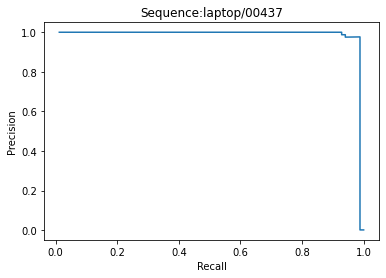

In [85]:
import matplotlib.pyplot as plt
plt.plot(r_at_k, p_at_k)
plt.ylabel('Precision')
plt.xlabel('Recall')
a=experiment.info_df["sequence_uid"].iloc[the_idx]
plt.title(f"Sequence:{a}")
plt.show()

In [86]:
from sklearn.metrics import auc
area_under_curve = auc(r_at_k,p_at_k)
area_under_curve

0.974909216992198

In [87]:
seq_uid_map = {}
for idx in range(len(similarity_matrix)):
    seq_uid = experiment.info_df["sequence_uid"].iloc[idx]
    seq_uid_map[idx]=seq_uid

In [88]:
seq_uid_count_map = {}
for seq_uid in tqdm(experiment.info_df["sequence_uid"].unique()):
    total_matches=(experiment.info_df["sequence_uid"]==seq_uid).sum()
    seq_uid_count_map[seq_uid]=total_matches

100%|██████████| 1156/1156 [00:02<00:00, 413.39it/s]


In [89]:
all_matches = np.argsort(similarity_matrix[0],axis=0)[::-1]

In [90]:
seq_uid_map

{0: 'cup/01442',
 1: 'camera/00368',
 2: 'book/01162',
 3: 'laptop/00295',
 4: 'laptop/00259',
 5: 'laptop/00799',
 6: 'cup/00110',
 7: 'book/01168',
 8: 'laptop/00471',
 9: 'shoe/01345',
 10: 'bottle/00306',
 11: 'bottle/00804',
 12: 'chair/01264',
 13: 'bottle/00928',
 14: 'laptop/00393',
 15: 'bottle/01308',
 16: 'chair/01458',
 17: 'shoe/01394',
 18: 'cup/00695',
 19: 'book/00320',
 20: 'cereal_box/00434',
 21: 'shoe/00983',
 22: 'chair/00911',
 23: 'laptop/01006',
 24: 'cereal_box/00118',
 25: 'laptop/00693',
 26: 'bottle/00955',
 27: 'chair/01296',
 28: 'laptop/00627',
 29: 'cup/00988',
 30: 'book/01049',
 31: 'bottle/01365',
 32: 'laptop/00256',
 33: 'chair/01369',
 34: 'shoe/01271',
 35: 'camera/00176',
 36: 'cup/00405',
 37: 'laptop/00393',
 38: 'book/00890',
 39: 'camera/00035',
 40: 'camera/00602',
 41: 'laptop/00437',
 42: 'chair/00100',
 43: 'book/00733',
 44: 'laptop/00063',
 45: 'chair/00169',
 46: 'shoe/01008',
 47: 'chair/00990',
 48: 'camera/00375',
 49: 'shoe/00211',

In [91]:
import random

In [102]:
re_id_ratios=[]
areas_under_curve = []
subset  = full_set = list(range(len(similarity_matrix)))
subset = random.sample(full_set, 15000)
r_at_ks = []
p_at_ks = []
seq_uids = []
for idx in tqdm(subset):
    #print(idx)
    local_matches  = np.argsort(similarity_matrix[idx],axis=0)[::-1]
    seq_uid = seq_uid_map[idx]
    #print(seq_uid)
    total_matches=seq_uid_count_map[seq_uid]
    match_or_not=np.zeros(len(local_matches))
    match_or_not=np.zeros(len(all_matches))
    match_count=0
    p_at_k=np.zeros(len(similarity_matrix))
    r_at_k=np.zeros(len(similarity_matrix))
    #print(p_at_k, r_at_k)
    last_r_at_k=0
    for k,match in enumerate(local_matches):
        #if seq_uid == experiment.info_df["sequence_uid"].iloc[match]:
        #print(seq_uid, match, seq_uid_map[match])
        if seq_uid == seq_uid_map[match]:
            match_count+=1
            match_or_not[k]=1
        else:
            match_or_not[k]=0
        #r = match_count/total_matches
        #if last_r_at_k!=r:
        r_at_k[k]=(match_count/total_matches)
        p_at_k[k]=match_count/(k+1)
    r_at_ks.append(r_at_k)
    p_at_ks.append(p_at_k)
    seq_uids.append(seq_uid)
        #last_r_at_k=
    area_under_curve = auc(r_at_k,p_at_k)
    #print(r_at_k)
    areas_under_curve.append(area_under_curve)
np.mean(areas_under_curve)

100%|██████████| 15000/15000 [13:39<00:00, 18.31it/s]


0.8877542898535362

In [94]:
p_r_by_category = {}
categories = ["bike","book","bottle","camera", "cereal_box", "chair","cup","laptop","shoe"]
for category in categories:
    p_r_by_category[category]={}
    p_r_by_category[category]["r_at_ks"] = []
    p_r_by_category[category]["p_at_ks"] = []
    p_r_by_category[category]["seq_uids"] = []
    for r_at_k, p_at_k, seq_uid in zip(r_at_ks, p_at_ks, seq_uids):
        if category in seq_uid:
            p_r_by_category[category]["r_at_ks"].append(r_at_k)
            p_r_by_category[category]["p_at_ks"].append(p_at_k)
            p_r_by_category[category]["seq_uids"].append(seq_uid)

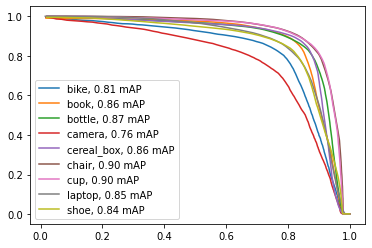

In [99]:
category = "bike"
f = plt.figure()
for category in categories:
    mean_r_at_k = np.array(p_r_by_category[category]["r_at_ks"]).mean(axis=0)
    mean_p_at_k = np.array(p_r_by_category[category]["p_at_ks"]).mean(axis=0)
    area_under_curve = auc(mean_r_at_k,mean_p_at_k)
    plt.plot(mean_r_at_k, mean_p_at_k, label=f"{category}, {area_under_curve:0.2f} mAP")
#plt.ylabel('Mean precision')
#plt.xlabel('Mean recall')
a=experiment.info_df["sequence_uid"].iloc[the_idx]
#plt.title(f"Precision/recall curve")
plt.legend()
plt.show()

In [101]:
f.savefig("reid_map.pdf", bbox_inches='tight')


In [ ]:
seq_uid_map[local_matches[0]]

In [ ]:
seq_uid_map[idx]

In [ ]:
subset

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
areas_under_curve

In [ ]:
np.mean(areas_under_curve)

In [ ]:
match_or_not.shape

In [ ]:
average_precision_score(np.ones(total_matches),match_or_not[0:total_matches])

In [ ]:
match_or_not.sum()

In [ ]:
match_or_not[50]

In [ ]:
match_count

In [ ]:
match_seq_uids

In [ ]:
len(all_matches_1)

In [ ]:
match_uid = [experiment.info_df["uid"].iloc[matches[i]] for i in list(experiment.info_df.index)]
experiment.info_df["match_uid"] = match_uid
experiment.info_df["match_sequence_uid"] = experiment.info_df["match_uid"].str.extract("hdf5_(\w+/\d+)_")
experiment.info_df["match_frame"] = experiment.info_df["match_uid"].str.extract("hdf5_\w+/\d+_(\d+)").astype(int)
experiment.info_df["frame"] = experiment.info_df["uid"].str.extract("hdf5_\w+/\d+_(\d+)").astype(int)

experiment.info_df

In [ ]:
same_sequence = (experiment.info_df["match_sequence_uid"]==experiment.info_df["sequence_uid"])
same_sequence.sum()/len(experiment.info_df)

Frame jitter (+- frame). Frames minimum frame increment is 5.

In [ ]:
same_sequence_df = experiment.info_df[same_sequence].copy()
same_sequence_df["delta_frame"] = same_sequence_df["frame"] - same_sequence_df["match_frame"] 
same_sequence_df["delta_frame"].abs().mean()

In [ ]:
idx = 10
experiment.load_hdf5_file()
query_im=experiment.get_image(idx, train=False)
query_im

In [ ]:
query_im.size

In [ ]:
#match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
match_idx= matches[idx]
res_im=experiment.get_image(match_idx, train=False)
res_im

In [27]:
match_idx

42525

In [28]:
experiment.train_info_df.iloc[match_idx]

category_id                         6
uid                hdf5_cup/01497_235
category                          cup
sequence_uid                cup/01497
frame                             NaN
video_id                          NaN
object_id                         NaN
batch_number                      NaN
sequence_number                   NaN
filepath                          NaN
filepath_full                     NaN
Name: 42525, dtype: object

In [69]:
experiment.info_df.iloc[idx]

category_id                          0
uid                hdf5_bike/00022_189
category                           NaN
sequence_uid                bike/00022
frame                              NaN
video_id                           NaN
object_id                          NaN
batch_number                       NaN
sequence_number                    NaN
filepath                           NaN
filepath_full                      NaN
Name: 91, dtype: object

In [70]:
#train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

In [71]:
from PIL import ImageDraw
points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)

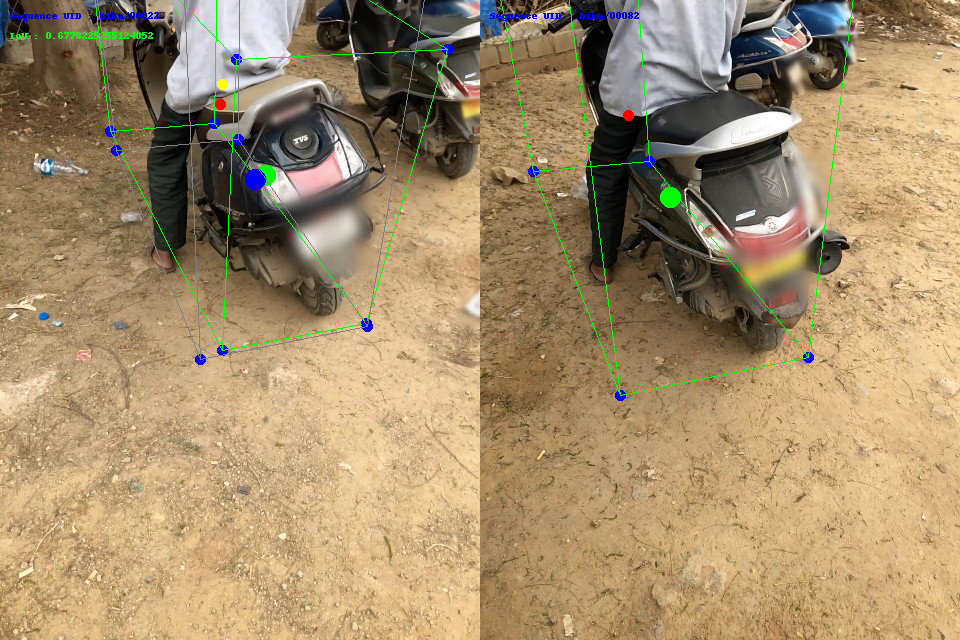

In [72]:
def get_preview(query_idx, match_idx):
    #query_im=Image.open(info_df.iloc[query_idx]["filepath_full"])
    canevas = Image.new('RGB', (480*2, 640))
    points_3d_result = zsp.get_bounding_box(query_idx, match_idx, experiment, adjust_scale=True)
    #points_3d_result=points_3d_result1
    query_im = experiment.get_image(query_idx, train=False)
    result_im = experiment.get_image(match_idx, train=True)
    #query_camera = zsp.get_camera(info_df, query_idx)
    query_intrinsics = experiment.get_intrinsics(query_idx, train=False)
    points_2d_query, points_3d_query = experiment.get_points(query_idx, train=False)
    points_2d_px_query = geo.points_2d_to_points2d_px(points_2d_query, 480, 640)
    
    points_2d_result_raw, points_3d_result_raw = experiment.get_points(match_idx, train=True)
    points_2d_px_result_raw = geo.points_2d_to_points2d_px(points_2d_result_raw, 480, 640)
    geo.draw_bbox(result_im,points_2d_px_result_raw)
    
    query_intrinsics = geo.scale_intrinsics(query_intrinsics, 1/3, 1/3)
    points2d_px_result = geo.project_3d_to_2d(points_3d_result, query_intrinsics)
    points2d_px_query = geo.project_3d_to_2d(points_3d_query, query_intrinsics)
    iou = zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))
    d = ImageDraw.Draw(query_im)
    iou_color = (255,0,0,255)
    if iou > 0.5:
        iou_color = (0,255,0,255)
    d.text((10,30),f"IoU : {iou}", fill=iou_color)
    
    query_sequence_uid = experiment.get_sequence_uid(query_idx, train=False)
    d.text((10,10),f"Sequence UID : {query_sequence_uid}", fill=(0,0,255,255))
    
    d = ImageDraw.Draw(result_im)
    result_sequence_uid = experiment.get_sequence_uid(match_idx, train=True)
    d.text((10,10),f"Sequence UID : {result_sequence_uid}", fill=(0,0,255,255))
    
    #print()
    geo.draw_bbox(query_im,points2d_px_result, line_color=iou_color)
    geo.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))
    canevas.paste(query_im)
    canevas.paste(result_im, (480,0))
    return canevas
display.display(get_preview(idx, match_idx))

In [73]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


slider = widgets.IntSlider(min=0, max=10000, step=1, value=10)

def f(x):
    idx =x 
    #match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
    match_idx = matches[idx]
    print(idx, match_idx)
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.display(get_preview(idx, match_idx))
interact(f, x=slider)


interactive(children=(IntSlider(value=10, description='x', max=10000), Output()), _dom_classes=('widget-intera…

<function __main__.f(x)>

In [80]:
experiment.info_df["sequence_uid"] = experiment.info_df["uid"].str.extract("hdf5_(\w+/\d+)_")
valid_sequences= sorted(list(experiment.info_df["sequence_uid"].unique()))
valid_sequence = valid_sequences[500]
valid_sequence

'cereal_box/01020'

In [81]:
from natsort import natsorted
df = experiment.info_df.query(f"sequence_uid=='{valid_sequence}'")
df["idx"]=df.index
df = df.set_index("uid")
df = df.reindex(index=natsorted(df.index))


/home/raphael/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



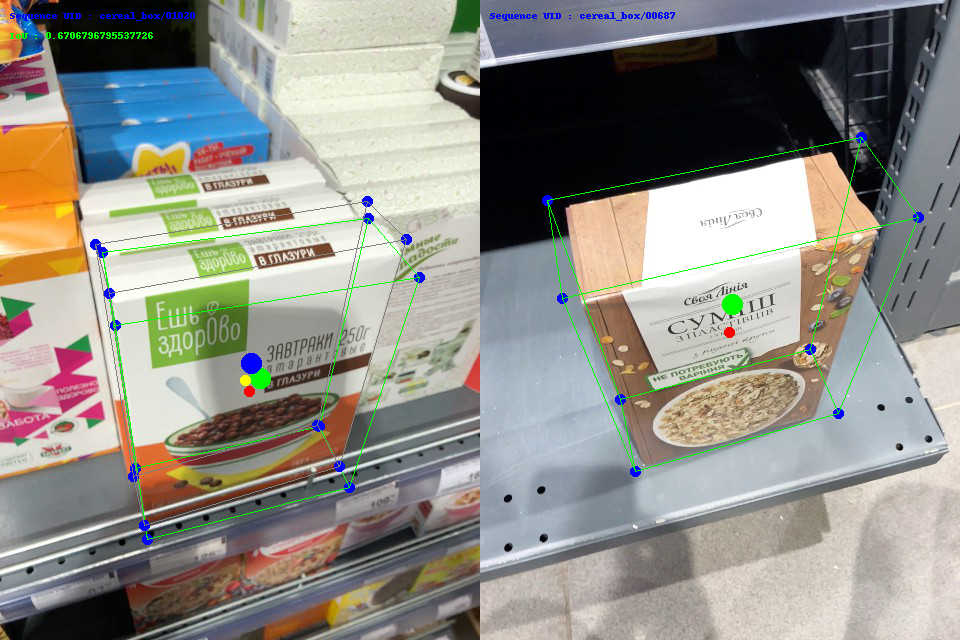

In [82]:
import time
idxs = list(df["idx"])
import cv2

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 5.0, (480*2,640))

for idx in idxs:
    match_idx = matches[idx]
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.clear_output(wait=True)
    preview_image = get_preview(idx, match_idx)
    display.display(preview_image)
    bgr_image = cv2.cvtColor(np.array(preview_image), cv2.COLOR_RGB2BGR)
    out.write(bgr_image)
    time.sleep(0.25)

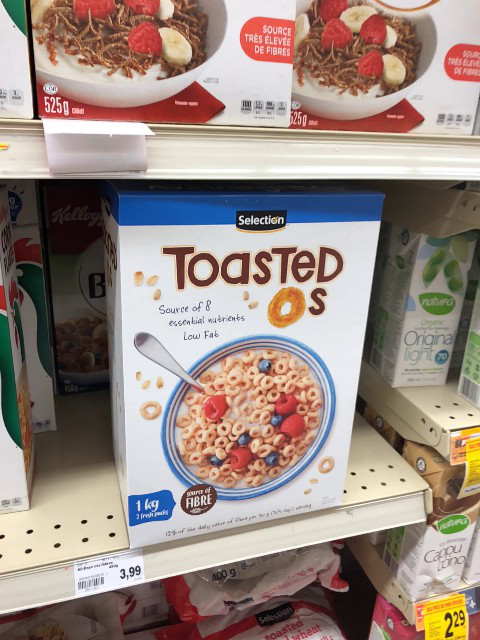

In [75]:
experiment.get_image(364121, train=True)

In [234]:
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"camera"], index=df.columns ), ignore_index=True)
    return df
points3d_df = build_df(points_3d_query, "query")
points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

0.43636998013146266

In [40]:
query_camera = zsp.get_camera(info_df, idx)

#result_camera = zsp.get_camera(train_info_df, train_idx)
#result_intrinsics = zsp.get_intrinsics(result_camera)
#result_intrinsics = zsp.scale_intrinsics(result_intrinsics, 0.25, 0.25)

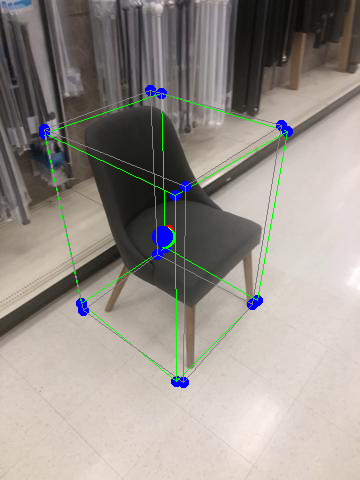

In [19]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [20]:

scale = zsp.get_bbox_area(query_bbox) / zsp.get_bbox_area(result_bbox)
scale

1.1055183682457537

In [21]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points_3d_result_centered, query_intrinsics, 2)
scale

1.052759184122877

In [22]:
points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
points3d_scaled

array([[-0.01861803, -0.04315793, -1.6003138 ],
       [ 0.31463464, -0.44888429, -1.84036112],
       [ 0.55302056, -0.01048551, -1.52644773],
       [-0.33932577, -0.44888345, -1.3437465 ],
       [-0.10094086, -0.01048463, -1.02983313],
       [ 0.06370481, -0.07583126, -2.17079547],
       [ 0.30208973,  0.36256757, -1.85688223],
       [-0.5902556 , -0.07583041, -1.67418085],
       [-0.35187069,  0.36256841, -1.36026761]])

In [23]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.7854928286905482

0 0.8131235878161949
1 0.8180783930713781
2 0.8191050178889032


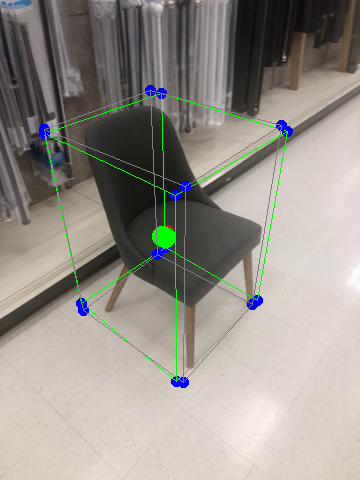

In [26]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
for i in range(0,3):
    obj_radius = zsp.get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
    print(i, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, query_intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, query_intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [27]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()